<a href="https://colab.research.google.com/drive/1eQOkYB4XMQdSeHV_pKvt9kSUW8vQo6LQ">Abre este Jupyter en Google Colab</a>

# Regresión Logística: Detección de SPAM

En este ejercicio se muestran los fundamentos de la Regresión Logística planteando uno de los primeros problemas que fueron solucionados mediante el uso de técnicas de Machine Learning: la detección de SPAM.

## Enunciado del ejercicio

Se propone la construcción de un sistema de aprendizaje automático capaz de predecir si un correo determinado se corresponde con un correo de SPAM o no, para ello, se utilizará el siguiente conjunto de datos:

##### [2007 TREC Public Spam Corpus](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo07)
The corpus trec07p contains 75,419 messages:

    25220 ham
    50199 spam

These messages constitute all the messages delivered to a particular
server between these dates:

    Sun, 8 Apr 2007 13:07:21 -0400
    Fri, 6 Jul 2007 07:04:53 -0400

### 0. Imports

In [1]:
# Instalación de librerías externas
!pip install scikit-learn
!pip install nltk

### 1. Funciones complementarias

En este caso práctico relacionado con la detección de correos electrónicos de SPAM, el conjunto de datos que disponemos esta formado por correos electrónicos, con sus correspondientes cabeceras y campos adicionales. Por lo tanto, requieren un preprocesamiento previo a que sean ingeridos por el algoritmo de Machine Learning.

In [4]:
# Esta clase facilita el preprocesamiento de correos electrónicos que poseen código HTML
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)

In [5]:
# Esta función se encarga de elimar los tags HTML que se encuentren en el texto del correo electrónico
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [6]:
# Ejemplo de eliminación de los tags HTML de un texto
t = '<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>'
strip_tags(t)

'Phrack World News'

Además de eliminar los posibles tags HTML que se encuentren en el correo electrónico, deben realizarse otras acciones de preprocesamiento para evitar que los mensajes contengan ruido innecesario. Entre ellas se encuentra la eliminación de los signos de puntuación, eliminación de posibles campos del correo electrónico que no son relevantes o eliminación de los afijos de una palabra manteniendo únicamente la raiz de la misma (Stemming). La clase que se muestra a continuación realiza estas transformaciones.

In [8]:
import email
import string
import nltk
nltk.download('stopwords')

class Parser:

    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        """Parse an email."""
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract the email content."""
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(),
                                   msg.get_content_type())
        content_type = msg.get_content_type()
        # Returning the content of the email
        return {"subject": subject,
                "body": body,
                "content_type": content_type}

    def get_email_body(self, payload, content_type):
        """Extract the body of the email."""
        body = []
        if type(payload) is str and content_type == 'text/plain':
            return self.tokenize(payload)
        elif type(payload) is str and content_type == 'text/html':
            return self.tokenize(strip_tags(payload))
        elif type(payload) is list:
            for p in payload:
                body += self.get_email_body(p.get_payload(),
                                            p.get_content_type())
        return body

    def tokenize(self, text):
        """Transform a text string in tokens. Perform two main actions,
        clean the punctuation symbols and do stemming of the text."""
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ")
        text = text.replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        # Stemming of the tokens
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Lectura de un correo en formato raw

In [10]:
inmail = open("datasets/trec07p/data/inmail.1").read()
print(inmail)

From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007
Return-Path: <RickyAmes@aol.com>
Received: from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From: "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To: "Tomas Jacobs" <RickyAmes@aol.com>
To: the00@speedy.uwaterloo.ca
Subject: Generic Cialis, branded quality@ 
Date: Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer: Microsoft Outlook Express 6.00.2600.0000
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--8896484051606557286"
X-Priority: 3
X-MSMail-Priority: Normal
Status: RO
Content-Length: 988
Lines: 24

----8896484051606557286
Content-Type: text/html;
Content-Transfer-Encoding: 7Bit

<html>
<body bgcolor="#ffffff">
<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0px; margin-bottom: 0px;" align="

##### Parsing del correo electrónico

In [16]:
p = Parser()
p.parse("datasets/trec07p/data/inmail.1")

{'subject': ['gener', 'ciali', 'brand', 'qualiti'],
 'body': ['do',
  'feel',
  'pressur',
  'perform',
  'rise',
  'occas',
  'tri',
  'viagra',
  'anxieti',
  'thing',
  'past',
  'back',
  'old',
  'self'],
 'content_type': 'multipart/alternative'}

##### Lectura del índice

Estas funciones complementarias se encargan cargar en memoria la ruta de cada correo electrónico y su etiqueta correspondiente {spam, ham}

In [19]:
index = open("datasets/trec07p/full/index").readlines()
##index

In [24]:
import os

DATASET_PATH = os.path.join("datasets", "trec07p")

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    index = open(path_to_index).readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1][:-1]
        path_mail = path.split("/")[-1]
        ret_indexes.append({"label":label, "email_path":os.path.join(DATASET_PATH, os.path.join("data", path_mail))})
    return ret_indexes

In [26]:
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]

In [28]:
indexes = parse_index("datasets/trec07p/full/index", 10)
indexes

[{'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.1'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.2'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.3'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.4'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.5'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.6'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.7'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.8'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.9'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.10'}]

### 2. Preprocesamiento de los datos del conjunto de datos

Con las funciones presentadas anteriormente se permite la lectura de los correos electrónicos de manera programática y el procesamiento de los mismos para eliminar aquellos componentes que no resultan de utilidad para la detección de correos de SPAM. Sin embargo, cada uno de los correos sigue estando representado por un diccionario de Python con una serie de palabras.

In [32]:
# Cargamos el índice y las etiquetas en memoria
index = parse_index("datasets/trec07p/full/index", 1)

In [34]:
# Leemos el primer correo
import os

open(index[0]["email_path"]).read()

'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0

In [36]:
# Parseamos el primer correo
mail, label = parse_email(index[0])
print("El correo es:", label)
print(mail)

El correo es: spam
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['do', 'feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


El algoritmo de Regresión Logística no es capaz de ingerir texto como parte del conjunto de datos. Por lo tanto, deben aplicarse una serie de funciones adicionales que transformen el texto de los correos electrónicos parseados en una representación numérica.

##### Aplicación de CountVectorizer

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Preapración del email en una cadena de texto
prep_email = [" ".join(mail['subject']) + " ".join(mail['body'])]

vectorizer = CountVectorizer()
X = vectorizer.fit(prep_email)

print("Email:", prep_email, "\n")
print("Características de entrada:", vectorizer.get_feature_names_out())

Email: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self'] 

Características de entrada: ['anxieti' 'back' 'brand' 'ciali' 'feel' 'gener' 'occas' 'old' 'past'
 'perform' 'pressur' 'qualitido' 'rise' 'self' 'thing' 'tri' 'viagra']


In [42]:
X = vectorizer.transform(prep_email)
print("\nValues:\n", X.toarray())


Values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


##### Aplicación de OneHotEncoding

In [45]:
from sklearn.preprocessing import OneHotEncoder

prep_email = [[w] for w in mail['subject'] + mail['body']]

enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(prep_email)

print("Features:\n", enc.get_feature_names_out())
print("\nValues:\n", X.toarray())

Features:
 ['x0_anxieti' 'x0_back' 'x0_brand' 'x0_ciali' 'x0_do' 'x0_feel' 'x0_gener'
 'x0_occas' 'x0_old' 'x0_past' 'x0_perform' 'x0_pressur' 'x0_qualiti'
 'x0_rise' 'x0_self' 'x0_thing' 'x0_tri' 'x0_viagra']

Values:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Funciones auxiliares para preprocesamiento del conjunto de datos

In [48]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}".format(i+1), end='')
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " ".join(mail['body']))
            y.append(label)
        except:
            pass
    print("X:", X[:15])
    print("y:", y[:15])
    return X, y

### 3. Entrenamiento del algoritmo 

In [51]:
# Leemos únicamente un subconjunto de 100 correos electrónicos
X_train, y_train = create_prep_dataset("datasets/trec07p/full/index", 100)

Parsing email: 100X: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self', 'typo debianreadmhi ive updat gulu i check mirror it seem littl typo debianreadm file exampl httpgulususherbrookecadebianreadm ftpftpfrdebianorgdebianreadm test lenni access releas diststest the current test develop snapshot name etch packag test unstabl pass autom test propog releas etch replac lenni like readmehtml yan morin consult en logiciel libr yanmorinsavoirfairelinuxcom 5149941556 to unsubscrib email debianmirrorsrequestlistsdebianorg subject unsubscrib troubl contact listmasterlistsdebianorg', 'authent viagramega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click httpwwwmoujsjkhchumcom authent viagra mega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click', 'nice talk yahey billi realli fun go night talk said felt insecur manhood i notic toilet quit small area worri websit i tell secret weapon ex

##### Aplicamos la vectorización a los datos

In [54]:
vectorizer = CountVectorizer(max_features=10, min_df=2, max_df=0.9)
X_train = vectorizer.fit_transform(X_train)

In [56]:
print(X_train.toarray())
print("\nFeatures:", len(vectorizer.get_feature_names_out()))

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  1]
 [10  0  0  4  0  0  4  0  6  0]
 [10  2  0  6  0  2  3  0  6  2]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 0  4  0  2  2  8  0  2  2  4]
 [ 0  0  0  4  1 10  0  2  6  4]
 [12  2  0  2  2  2  1  0  2  8]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  2 10  2 10  0  0  2  0  2]
 [ 0  0  0  0  0  1  0  2  0  1]
 [ 6  2  0  4  0  2  3  4  3  4]
 [10  4  0  6  0  0  0  2  6  2]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  2  4  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  4  6]
 [ 0  1  0  0  0  0  0  1  0  1]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0

In [58]:
import pandas as pd

pd.DataFrame(X_train.toarray(), columns=[vectorizer.get_feature_names_out()])

,comput,get,hgh,it,life,mani,new,one,peopl,the
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1
2,0,0,0,2,0,0,0,0,0,0
3,0,0,0,0,0,1,0,2,0,1
4,10,0,0,4,0,0,4,0,6,0
...,...,...,...,...,...,...,...,...,...,...
93,0,0,0,0,0,0,0,0,0,0
94,0,0,0,1,2,0,2,10,4,1
95,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0


In [60]:
y_train

['spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam']

###### Entrenamiento del algoritmo de regresión logística con el conjunto de datos preprocesado

In [63]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

### 4. Predicción

##### Lectura de un conjunto de correos nuevos

In [67]:
# Leemos 150 correos de nuestro conjunto de datos y nos quedamos únicamente con los 50 últimos 
# Estos 50 correos electrónicos no se han utilizado para entrenar el algoritmo
X, y = create_prep_dataset("datasets/trec07p/full/index", 150)
X_test = X[100:]
y_test = y[100:]

Parsing email: 150X: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self', 'typo debianreadmhi ive updat gulu i check mirror it seem littl typo debianreadm file exampl httpgulususherbrookecadebianreadm ftpftpfrdebianorgdebianreadm test lenni access releas diststest the current test develop snapshot name etch packag test unstabl pass autom test propog releas etch replac lenni like readmehtml yan morin consult en logiciel libr yanmorinsavoirfairelinuxcom 5149941556 to unsubscrib email debianmirrorsrequestlistsdebianorg subject unsubscrib troubl contact listmasterlistsdebianorg', 'authent viagramega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click httpwwwmoujsjkhchumcom authent viagra mega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click', 'nice talk yahey billi realli fun go night talk said felt insecur manhood i notic toilet quit small area worri websit i tell secret weapon ex

##### Preprocesamiento de los correos con el vectorizador creado anteriormente

In [70]:
X_test = vectorizer.transform(X_test)

##### Predicción del tipo de correo

In [73]:
y_pred = clf.predict(X_test)
y_pred

array(['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam'], dtype='<U4')

In [75]:
print("Predicción:\n", y_pred)
print("\nEtiquetas reales:\n", y_test)

Predicción:
 ['spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam']

Etiquetas reales:
 ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam']


##### Evaluación de los resultados

In [78]:
from sklearn.metrics import accuracy_score

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.891


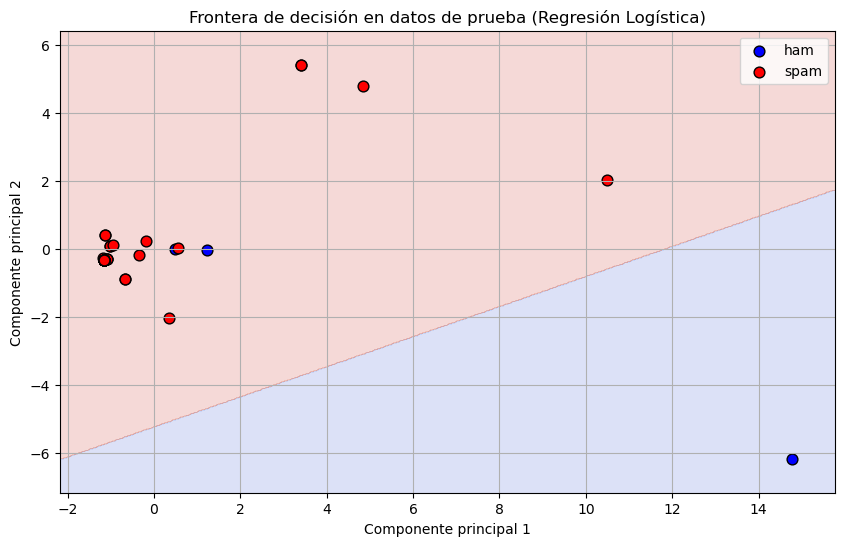

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# 1. Asegúrate de tener etiquetas codificadas numéricamente
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # 'spam'/'ham' → 0/1

# 2. Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test.toarray())

# 3. Entrenar clasificador sobre los datos de test (solo para visualizar frontera)
clf = LogisticRegression()
clf.fit(X_2d, y_test_encoded)

# 4. Crear malla para la frontera de decisión
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 5. Predecir sobre la malla
Z = clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# 6. Graficar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

# 7. Puntos reales (test)
colors = ['blue', 'red']
for i, label in enumerate(label_encoder.classes_):  # 'ham', 'spam'
    idx = y_test_encoded == i
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], c=colors[i], label=label, edgecolors='k', s=60)

plt.title("Frontera de decisión en datos de prueba (Regresión Logística)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()